# A-gs model and implementation (simulation CO2 and H2O flux)

## Initialize data and model

### Setup and fetch data

In [1]:
# Settings
Username   = 'Beheerder'
years      = range(2001,2021)    #(1997,2021) # Set years to download

In [2]:
import os
datapath = os.path.join('../')
#print('datapath is set to %s'%datapath)

# !pip install numpy
# !pip install pandas
# !pip install matplotlib
# !pip install plotly 
# !pip install cufflinks
#!pip install colorspacious
#!pip install seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import plotly.express as px
#import cufflinks as cf
import matplotlib.dates as mdate
import matplotlib.ticker as ticker
from matplotlib import cm
#from colorspacious import cspace_converter
import scipy.stats as stats
#cf.go_offline()
#cf.set_config_file(offline=False, world_readable=True)

from datetime import datetime, timedelta
import sys
sys.path.insert(0, os.path.join(datapath,'PythonScripts'))
from Loobos_Toolbox import dateparse, dateparse_Gapfilled, Read_LoobosEddFinal, Read_LooStor, Read_LoodatGapfill, Read_Loobos_halfhourly, Read_Loobos_meteo, Read_Loobos_soil, Read_Loobos_profile
from Ags_model import runAgs, calc_LE

In [3]:
import matplotlib.dates as mdates

In [4]:
#these next two lines are to prevent re-loading the data. If you want to re-load data, instead comment them out
if not 'progress' in globals(): progress = list()
if not 'dataloaded' in progress:
  # Read files
    df_EC           = Read_LoobosEddFinal    (years,datapath)
    df_Stor         = Read_LooStor           (years,datapath)
    df_Comb         = Read_LoodatGapfill     (years,datapath)
    df_NEE          = Read_Loobos_halfhourly (years,datapath)
    df_meteo        = Read_Loobos_meteo      (years,datapath)
    df_soil         = Read_Loobos_soil       (years,datapath) 
    df_profile      = Read_Loobos_profile    (years,datapath)
    progress.append('dataloaded')

Loading 2001
Loading 2002
Loading 2003
Loading 2004
Loading 2005
Loading 2006
Loading 2007
Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
Loading 2019
Loading 2020
df_EC loaded. Columns in this dataframe:
Index(['Doy', 'Dtime', 'Flx_Tsonic', 'Flx_Lo-H2O', 'Flx_Lo-CO2', 'Qf_Tsonic',
       'Qf_Lo-H2O', 'Qf_Lo-CO2', 'Mea_Windsp', 'Mea_Tsonic', 'Mea_Lo-H2O',
       'Mea_Lo-CO2', 'U-star', 'Z-over-L', 'Wind-Dir', '80PercFlux'],
      dtype='object')
Loading 2001
Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003
Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2005
Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2007
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017
Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2019
Loading 2020


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:80: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_Stor       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_Stor loaded. Columns in this dataframe:
Index(['Day', 'Time', 'TotalT', 'TotalTflux', 'TotalH2O', 'TotalH2Oflux',
       'TotalCO2', 'TotalCO2flux', 'CO2-2.5m', 'CO2flux-2.5m'],
      dtype='object')
Loading 2001
Loading 2002
Loading 2003
Loading 2004
Loading 2005
Loading 2006
Loading 2007
Loading 2008
Loading 2009
Loading 2010
Loading 2011
Loading 2012
Loading 2013
Loading 2014
Loading 2015
Loading 2016
Loading 2017
Loading 2018
Loading 2019
Loading 2020
df_Comb loaded. Columns in this dataframe:
Index(['Year', 'DoY', 'Hour', 'qcNEE', 'NEE', 'LE', 'H', 'Rg', 'Tair', 'Tsoil',
       'rH', 'Ustar', 'VPD', 'NEE_orig', 'NEE_f', 'NEE_fqc', 'NEE_fall',
       'NEE_fall_qc', 'NEE_fnum', 'NEE_fsd', 'NEE_fmeth', 'NEE_fwin',
       'Rg_orig', 'Rg_f', 'Rg_fqc', 'Rg_fall', 'Rg_fall_qc', 'Rg_fnum',
       'Rg_fsd', 'Rg_fmeth', 'Rg_fwin', 'H_orig', 'H_f', 'H_fqc', 'H_fall',
       'H_fall_qc', 'H_fnum', 'H_fsd', 'H_fmeth', 'H_fwin', 'LE_orig', 'LE_f',
       'LE_fqc', 'LE_fall', 'LE_fall_qc', 'L

C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2003
Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2005
Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2007
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2017
Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Loading 2019
Loading 2020


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:126: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_tmp      = pd.read_csv(infilename, index_col='DateTime'   , parse_dates=['DateTime'   ], date_parser=dateparse_Gapfilled)


Done
df_NEE loaded. Columns in this dataframe:
Index(['NEE_f', 'H_f', 'LE_f', 'Reco_f', 'GPP_f', 'NEE_fqc', 'H_fqc', 'LEfqc',
       'Reco', 'Tair', 'Rg_f', 'VPD', 'Tsoil', 'rH', 'Ustar', 'R-ref', 'E_0'],
      dtype='object')
Loading 2001


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2005
Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2007


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2010
Loading 2011


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2014
Loading 2015


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017
Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2019
Loading 2020


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:171: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_meteo     .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_meteo loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'S(i)', 'S(o)', 'L(i)', 'L(o)', 'G1', 'PAR',
       'H2OLic', 'CO2Lic', '-q', 'Te(vaisal)', 'Te-L(i)', 'Te-L(o)', '-u(z)',
       '-u(dir)', 'Min u(z)', 'WSC therm', 'SD S(i)', 'SD S(o)', 'SD L(i)',
       'SD L(o)', 'SD G1', 'SD PAR', 'SD H2OLic', 'SD CO2Lic', 'SD q',
       'SD Te(vaisal)', 'Battery V', 'CR10 temp', 'P(mast)00', 'P(guter)00',
       'P(mast)05', 'P(guter)05', 'P(mast)10', 'P(guter)10', 'P(mast)15',
       'P(guter)15', 'P(mast)20', 'P(guter)20', 'P(mast)25', 'P(guter)25',
       'P(mast)', 'P(guter)', 'P(field)', 'L(i)corr', 'L(o)corr', 'R(net)',
       'P(guter)corr', 'Pcorr', 'PARrefl', 'PARdiff', 'H2Olic', 'CO2lic',
       'Vbatt', 'CR10temp', 'SD u(z)', '#NAME?', '#NAME?.1', '#NAME?.2'],
      dtype='object')
Loading ../\Soilmoist\Final\Loosoifinal01.csv...
Loading ../\Soilmoist\Final\Loosoifinal02.csv...
Loading ../\Soilmoist\Final\Loosoifinal03.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future vers

Loading ../\Soilmoist\Final\Loosoifinal04.csv...
Loading ../\Soilmoist\Final\Loosoifinal05.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future vers

Loading ../\Soilmoist\Final\Loosoifinal06.csv...
Loading ../\Soilmoist\Final\Loosoifinal07.csv...
Loading ../\Soilmoist\Final\Loosoifinal08.csv...
Loading ../\Soilmoist\Final\Loosoifinal09.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal10.csv...
Loading ../\Soilmoist\Final\Loosoifinal11.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal12.csv...
Loading ../\Soilmoist\Final\Loosoifinal13.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal14.csv...
Loading ../\Soilmoist\Final\Loosoifinal15.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal16.csv...
Loading ../\Soilmoist\Final\Loosoifinal17.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal18.csv...
Loading ../\Soilmoist\Final\Loosoifinal19.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading ../\Soilmoist\Final\Loosoifinal20.csv...


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:188: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_soil       .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_soil loaded. Columns in this dataframe:
Index(['Time', 'Daynumber', 'Year', 'EC200', 'EC201', 'EC202', 'EC203',
       'EC204', 'EC205', 'EC206', 'EC207', 'EC208', 'EC209', 'Temp200',
       'Temp201', 'Temp202', 'Temp203', 'Temp204', 'Temp205', 'Temp206',
       'Temp207', 'Temp208', 'Temp209', 'Eps200co', 'Eps201co', 'Eps202co',
       'Eps203co', 'Eps204co', 'Eps205co', 'Eps206co', 'Eps207co', 'Eps208co',
       'Eps209co', 'SM-Lit', 'SM-003', 'SM-020', 'SM-050', 'SM-100', 'ST-Lit',
       'ST-003', 'ST-020', 'ST-050', 'ST-100', 'T-bole'],
      dtype='object')
Loading 2001
Loading 2002


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2003
Loading 2004


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2005
Loading 2006


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future vers

Loading 2007
Loading 2008


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2009
Loading 2010


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2011
Loading 2012


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2013
Loading 2014


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2015
Loading 2016


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2017
Loading 2018


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


Loading 2019
Loading 2020


C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))
C:\Users\feder\Workspace\Thesis\PythonScripts\../PythonScripts\Loobos_Toolbox.py:233: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df_profile    .append(pd.read_csv(infilename, index_col='YearDayTime', parse_dates=['YearDayTime'], date_parser=dateparse))


df_profile loaded. Columns in this dataframe:
Index(['Daynumber', 'Time', 'Vtemptop', 'Vtempmid', 'Vtempbot', 'VaiVPtop',
       'VaiVPmid', 'Pressure', 'VecWStop', 'VecWSmid', 'VecWSbot', 'H2Olevel1',
       'H2Olevel2', 'H2Olevel3', 'H2Olevel4', 'H2Olevel5', 'CO2level1',
       'CO2level2', 'CO2level3', 'CO2level4', 'CO2level5', 'H2Ocal', 'CO2cal'],
      dtype='object')


In [5]:
# Make filter for GPP orginial data and not gapfilled
#General filters
I = ((df_Comb['GPP_fqc']==0)&(df_meteo['PAR']>0))
#t = df_profile.index                                          
#time = (t < np.datetime64('2013-05-08')) | (t > np.datetime64('2013-06-01'))

# Filter for CO2 data
CO2_filt = (df_profile['CO2level1'] > 300)

# Filter for L(o)corr data
Locorr_filt = (df_meteo['L(o)corr']>0) 

# Filter for VPD data
VPD_filt = (df_Comb['VPD']>=0)

# Filter for U-star
Ustar_filt = (df_EC['U-star']>=0)

# Combine all filters
filter = I & CO2_filt & Locorr_filt & VPD_filt & Ustar_filt

#Column 'CO2' is input from df_profile
df_profile_filter = df_profile[filter]

#Column 'L(o)corr' and 'PAR' are inputs from df_meteo
df_meteo_filter = df_meteo[filter]

#Columns 'VPD' and 'Tair' are inputs from df_Comb
df_Comb_filter = df_Comb[filter]

# Columns 'Mea_Windsp' and 'U-star' are inputs from df_EC
df_EC_filter = df_EC[filter]

## import rain

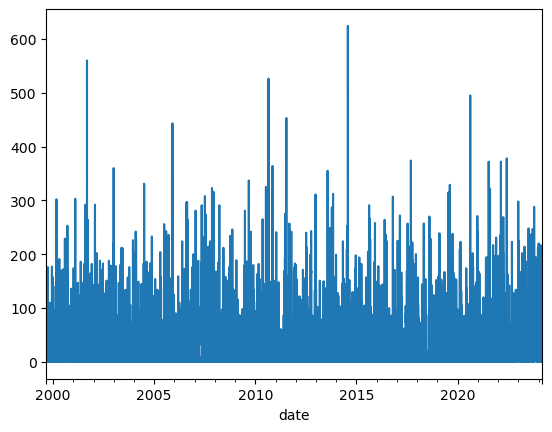

In [6]:
#datapath = os.path.join('../KNMI_regen')
#print(datapath)
knmi_regen=pd.read_csv('../KNMI_regen/neerslaggeg_KOOTWIJK-RADIO_567.txt',sep=',',header=17)
knmi_regen=knmi_regen.iloc[28000:] #remove dataset before ~november 2007
#knmi_regen=knmi_regen.iloc[31000:] #remove dataset before ~november 2007
knmi_regen['date']=pd.to_datetime(knmi_regen['YYYYMMDD'],yearfirst=True,format='%Y%m%d')
knmi_regen.index=knmi_regen['date']
knmi_regen=knmi_regen.rename(columns={"   RD": "RD", "   SX": "SX"}) #for some reason there's spaces in some of the column names, removing them.
knmi_regen=knmi_regen.astype({"RD": np.intc})
knmi_regen['RD'].plot() #Column RD is is rain daily sum, SX is code related to snow. If unnamed contains 4 spaces it's also a code for snow. STN is station ID.
df_rain=knmi_regen.loc[:,['RD']].resample('3H').ffill()
#df_rain

## import fstr

In [6]:
## import fstr
df_fstr = pd.read_csv('./fstrOutput/fstr_1D_norainydays.csv')
#df_fstr = pd.read_csv('./fstrOutput/fstr_30m_norainydays.csv')
#df_fstr = pd.read_csv('./fstrOutput/fstr_3H_norainydays.csv')
#df_fstr = pd.read_csv('./fstrOutput/fstr_7D_norainydays.csv')

In [24]:
if df_fstr.index.name != 'dateindex':
    df_fstr.rename(columns={'Unnamed: 0':'dateindex'},inplace=True)
    df_fstr['dateindex']=pd.to_datetime(df_fstr['dateindex'])
    df_fstr.index=df_fstr['dateindex']
    df_fstr.drop(columns=['dateindex'], inplace=True)
#df_fstr

### Run A-gs model

In [7]:
# Run A-gs model

an_final,an_umol,rs, ra = runAgs(df_profile_filter,df_Comb_filter,df_meteo_filter,df_EC_filter,fstr=1.0)

## Calcuate ET

### Assemble dataframe 'df_ET' that will hold output and fill with inputs

In [8]:
def init_ETframe(rs_series):
    df_ET = pd.concat([df_meteo['L(o)'],df_meteo['Te-L(o)'],df_profile['Pressure'],df_Comb['VPD'],df_Comb['rH'],df_meteo['P(mast)']],axis=1,sort=False)
    #convert Pressure from hPa to kPa 
    df_ET['p_kPa']=df_ET['Pressure']/10
    df_ET['VPD_adj']=df_ET['VPD'].loc[df_ET['VPD']>0] #some outlier values for VPD are negative, remove from dataset
    df_ET['VPD_adj']=df_ET['VPD_adj']/10  # VPD from df_Comb is in hPa, I need kPa, so hPa/10 = kPa
    df_ET['rs']=rs_series.to_frame(name="rs")
    df_ET['ra']=ra.to_frame(name="ra")
    return df_ET

In [9]:
df_ET=init_ETframe(rs)

In [10]:
df_ET=calc_LE(df_ET)

In [12]:
df_ET_meas=df_Comb_filter.copy()
df_ET_meas=df_ET_meas.loc[df_ET_meas['LE']>=0]
#df_ET_meas=df_ET_meas.resample("M").mean()
#df_ET_meas['LE'].plot()

### calculate ET

### H2O flux

In [9]:
# Add in precipitation last 3h and 24 hour values so it can be used for filtering
df_ET['last3day_prec']=df_ET['P(mast)'].rolling('72H').sum()

## fstr analysis

### step 1 assemble dataframe and chop up according to each week

In [15]:
    #st="2017-06-01" 
    #ed="2017-12-30"
#df_meteo['L(o)corr'].loc[df_meteo['L(o)corr']>0].plot()
#df_meteo.loc[st:ed,'L(o)corr'].plot()
    #df_meteo['L(o)corr'].plot()

In [48]:
df_tmp30m=pd.DataFrame()
df_tmp30m['ET']=df_ET['ET_VPD']
df_tmp30m['P(mast)']=df_ET['P(mast)']
df_tmp30m=df_tmp30m.dropna()

In [13]:
df_tmp30m=pd.DataFrame()
df_tmp30m['ET']=df_ET['ET_VPD']
df_tmp30m['P(mast)']=df_ET['P(mast)']
df_tmp30m=df_tmp30m.dropna()

df_LE=df_Comb['LE'].loc[df_Comb['LE']>=0]
df_tmp30m=df_tmp30m.merge(df_LE, how='inner',left_index=True, right_index=True)

#df_tmp30['ET/LE']=df_tmp30['ET']/df_tmp30['LE']
#df_tmp30m['LE/ET']=df_tmp30m['LE']/df_tmp30m['ET'] #<- this is the one we want, observations/model. If obs/model = fstr, then model*fstr= model(obs/model) = obs

df_tmp30m['P_3day']=df_tmp30m['P(mast)'].rolling('72H').sum()
#df_tmp30m=df_tmp30m.loc[df_tmp30m['P_3day']==0]

df_tmp3h=df_tmp30m.resample('3H').mean()#.between_time("09:00", "15:00")
df_tmp3h['P(mast)']=df_tmp30m['P(mast)'].resample('3H').sum() #overwrite the averaged pmast with sum pmast
df_tmp3h['P_3day']=df_tmp3h['P(mast)'].rolling('72H').sum() #overwrite the correct P_3day

#remove rainy days through knmi data
df_tmp3h['RD']=df_rain['RD']
df_tmp3h['RD']=df_tmp3h['RD']/10 #convert from tenths of mm to mm
df_tmp3h=df_tmp3h.loc[df_tmp3h['RD']==0]

#remove rainy days through Pmast
df_rain3h_dailymax=df_tmp3h['P(mast)'].resample('1D').sum().resample('3H').ffill()
df_rain3h_dailymax=df_rain3h_dailymax[:-1] #remove last entry because all 3h frames end on 21:00 not 00:00
df_rain3h_dailymax=df_rain3h_dailymax.rename('P(mast)Dmax')
df_tmp3h['P(mast)Dmax']=df_rain3h_dailymax
df_tmp3h=df_tmp3h.loc[df_tmp3h['P(mast)Dmax']==0]

#manual filter remove bad days
listofdates =  ['2008-08-24',
                '2010-05-11',
                '2010-08-04',
                '2012-06-13',
                '2013-05-10',
                '2013-05-19',
                '2014-06-16',
                '2017-04-22']

#for date in listofdates:
#    df_tmp3h.loc[date+' 00:00':date+' 21:00','ET'] = np.nan
#    df_tmp3h.loc[date+' 00:00':date+' 21:00','LE'] = np.nan

#remove hours outside of 9:00 and 15:00
df_tmp3h=df_tmp3h.between_time("09:00", "15:00")

#resample to daily
df_tmp1d=df_tmp3h.resample('1D').mean()
df_tmp1d['doy']=df_tmp1d.index.dayofyear
df_tmp1d['P(mast)sum']=df_tmp3h['P(mast)'].resample('1D').sum()
df_tmp1d['LE/ET']=df_tmp1d['LE']/df_tmp1d['ET']

#resample to weekly (7 days)
df_tmp7d=df_tmp3h.resample('7D').mean()
df_tmp7d['LE/ET']=df_tmp7d['LE']/df_tmp7d['ET']

## plotting weekly fstr

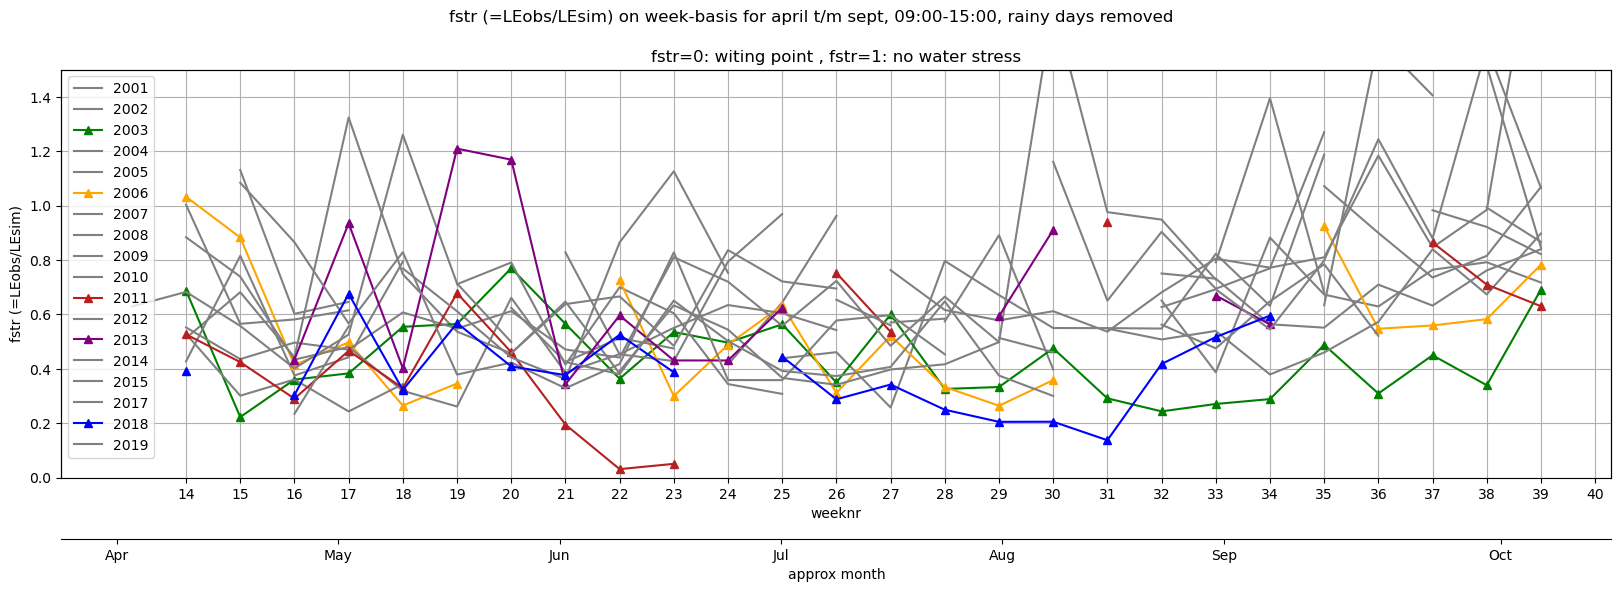

In [16]:
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20,6)

#remove non-growthseason values
df_tmp7d=df_tmp7d.loc[(df_tmp7d.index.month>=4) & (df_tmp7d.index.month<=9)]

df_tmp7d['weeknr']=df_tmp7d.index.isocalendar().week

#df_tmp7d=df_tmp7d.loc[df_tmp7d['LE/ET']<=1.0]

#df_tmp

#df_tmp['ET/LE'].plot(ylim=(0,15))

fig,ax = plt.subplots()
ax.set_ylim(0,1.5)
ax.set_ylabel('fstr (=LEobs/LEsim)')
ax.set_xlabel('weeknr')

plt.xticks([x for x in range(14,41)]) #this sets the xticks for the main x-axis with the weeknr
locs, labels=plt.xticks() #this same function with no argument gets the position and labels and stores them for later

ax2 = ax.twiny()
fig.subplots_adjust(bottom=0.2)

# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")

# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.15))

# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)

ax2.set_xlabel('approx month')
ax2.set_xlim(13,41)
ax2.set_xticks([14, 18, 22, 26,  30, 34, 39])
ax2.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct'])

colored_years={'2003':'green','2006':'orange','2011':'#b62020','2013':'purple','2018':'blue'}

for year in ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2017','2018','2019']:
    start=year+'-01-01 01:00'
    end=year+'-12-23 23:00'
    if year in colored_years.keys():
        color=colored_years[year]
        marker='^'
    else:
        color='grey'
        marker=''
    #marker={'2008':'^','2009':'^','2010':'^','2011':'^','2012':'o','2013':'^','2014':'o','2015':'^','2016':'o','2017':'o','2018':'^'}
    #colors={'2008':'#b62020','2009':'#cb2424','2010':'^','2011':'^','2012':'o','2013':'^','2014':'o','2015':'^','2016':'o','2017':'o','2018':'^'}
    #df_tmp.loc[start:end,'ET/LE'].plot(x=df_tmp.loc[start:end,'weeknr'],ylim=(0,15))
    ax.plot(df_tmp7d.loc[start:end,'weeknr'],df_tmp7d.loc[start:end,'LE/ET'], marker=marker,color=color ,label=year) #marker=marker[year]
ax.legend(loc=("upper left"))
fig.suptitle('fstr (=LEobs/LEsim) on week-basis for april t/m sept, 09:00-15:00, rainy days removed')
ax.set_title('fstr=0: witing point , fstr=1: no water stress')
ax.grid()

In [249]:
st="2014-04-22"
ed="2014-06-28"
#df_tmp30.loc[st:ed,'ET'].plot()
#df_tmp30.loc[st:ed,'LE'].plot()
#df_ET.loc[st:ed,'P(mast)'].plot()

#df_tmp.loc[st:ed]
#df_ET.loc[st:ed,'P(mast)'].plot()

In [17]:
df_tmp30['fstr_over1']=df_tmp30['LE/ET']>1

print(df_tmp30['fstr_over1'].sum())
print(df_tmp30.size)
print(df_tmp30['fstr_over1'].sum()/df_tmp30.size)

#df_tmp30#=df_tmp30.resample('3H').mean()#.between_time("09:00", "15:00")


NameError: name 'df_tmp30' is not defined

In [ ]:
df_tmp30['LE/ET'].plot(kind=)

# Groundwater

## Import Groundwater data

In [26]:
df_GWS = pd.read_csv('./GWS_daily.csv')

In [30]:
if df_GWS.index.name != 'datetime':
    df_GWS['datetime']=pd.to_datetime(df_GWS['datetime'])
    df_GWS.index=df_GWS['datetime']
    df_GWS.drop(columns=['datetime'], inplace=True)

In [ ]:
df_GWS_multi = pd.read_csv('./GWS_multi_daily.csv')

In [36]:
if df_GWS_multi.index.name != 'dateindex':
    df_GWS_multi.rename(columns={'Unnamed: 0':'dateindex'},inplace=True)
    df_GWS_multi['dateindex']=pd.to_datetime(df_GWS_multi['dateindex'])
    df_GWS_multi.index=df_GWS_multi['dateindex']
    df_GWS_multi.drop(columns=['dateindex'], inplace=True)

In [41]:
df_GWS

,depth,depth_anom_all
datetime,,
2001-01-15,109.000000,-82.788726
2001-01-16,108.857143,-82.931583
2001-01-17,108.714286,-83.074440
2001-01-18,108.571429,-83.217298
2001-01-19,108.428571,-83.360155
...,...,...
2019-12-27,249.000000,57.211274
2019-12-28,248.000000,56.211274
2019-12-29,247.000000,55.211274


In [43]:
df_GWS_multi

,yeardate,monthday,depth_2001,depth_2001_diff,depth_2001_anom,depth_2002,depth_2002_diff,depth_2002_anom,depth_2003,depth_2003_diff,...,depth_2016_anom,depth_2017,depth_2017_diff,depth_2017_anom,depth_2018,depth_2018_diff,depth_2018_anom,depth_2019,depth_2019_diff,depth_2019_anom
dateindex,,,,,,,,,,,,,,,,,,,,,
2000-04-01,2000-04-01,04-01,93.160000,0.000000,-104.263859,84.133333,0.000000,-113.290525,124.0,0.0,...,-19.423859,205.0,0.0,7.576141,196.0,0.0,-1.423859,213.0,0.0,15.576141
2000-04-02,2000-04-02,04-02,93.613333,0.453333,-103.810525,84.766667,0.633333,-112.657192,123.0,-1.0,...,-20.423859,206.0,1.0,8.576141,195.0,-1.0,-2.423859,213.0,0.0,15.576141
2000-04-03,2000-04-03,04-03,94.066667,0.906667,-103.357192,85.400000,1.266667,-112.023859,124.0,0.0,...,-20.423859,207.0,2.0,9.576141,194.0,-2.0,-3.423859,214.0,1.0,16.576141
2000-04-04,2000-04-04,04-04,94.520000,1.360000,-102.903859,86.033333,1.900000,-111.390525,124.0,0.0,...,-19.423859,207.0,2.0,9.576141,193.0,-3.0,-4.423859,214.0,1.0,16.576141
2000-04-05,2000-04-05,04-05,94.973333,1.813333,-102.450525,86.666667,2.533333,-110.757192,123.0,-1.0,...,-18.423859,207.0,2.0,9.576141,194.0,-2.0,-3.423859,215.0,2.0,17.576141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-26,2000-10-26,10-26,126.142857,32.982857,-71.281002,172.000000,87.866667,-25.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,294.0,98.0,96.576141,282.0,69.0,84.576141
2000-10-27,2000-10-27,10-27,126.428571,33.268571,-70.995287,169.000000,84.866667,-28.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,293.0,97.0,95.576141,282.0,69.0,84.576141
2000-10-28,2000-10-28,10-28,126.714286,33.554286,-70.709573,169.000000,84.866667,-28.423859,213.0,89.0,...,56.576141,265.0,60.0,67.576141,294.0,98.0,96.576141,281.0,68.0,83.576141


## plot groundwater data

### Plot all years one plot

,depth,depth_anom_all
datetime,,
2001-01-15,109.000000,-82.788726
2001-01-16,108.857143,-82.931583
2001-01-17,108.714286,-83.074440
2001-01-18,108.571429,-83.217298
2001-01-19,108.428571,-83.360155
...,...,...
2019-12-27,249.000000,57.211274
2019-12-28,248.000000,56.211274
2019-12-29,247.000000,55.211274


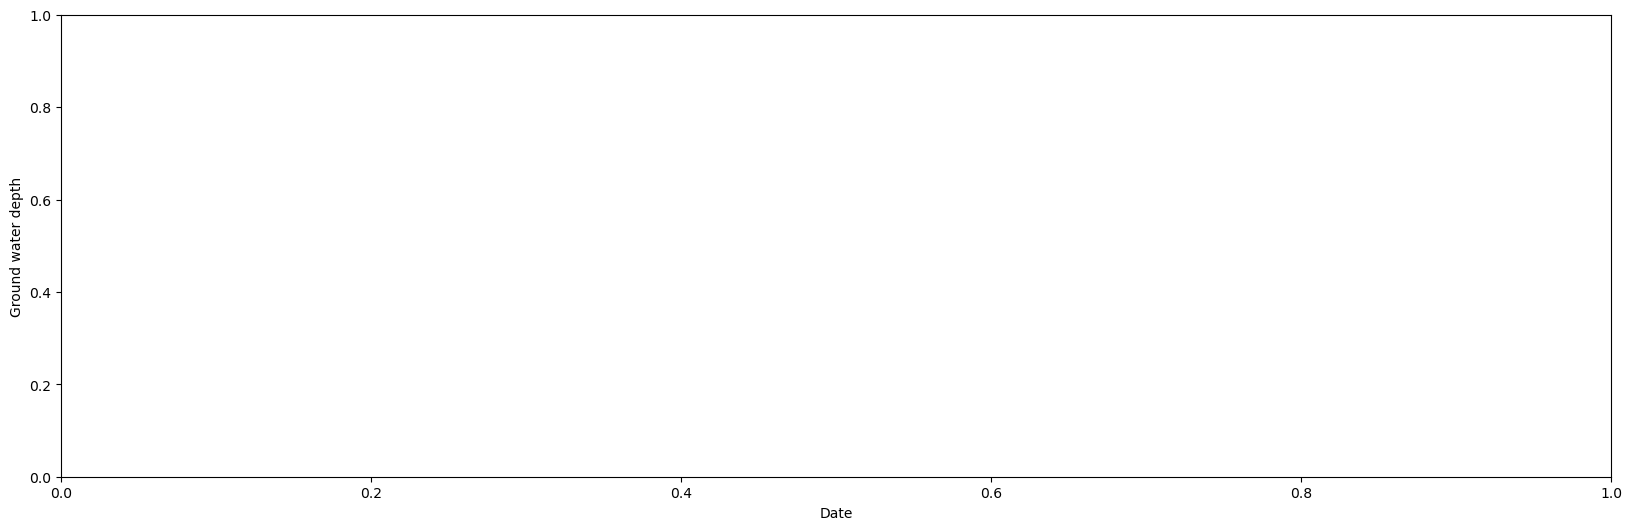

In [53]:
fig,ax = plt.subplots()
#ax.set_ylim(0,1.5)
ax.set_ylabel('Ground water depth')
ax.set_xlabel('Date')

df_GWS

### Plot change since april

In [69]:
#emergency change from 1st jan to april

df_GWS_multi

,yeardate,monthday,depth_2001,depth_2001_diff,depth_2001_anom,depth_2002,depth_2002_diff,depth_2002_anom,depth_2003,depth_2003_diff,...,depth_2016_anom,depth_2017,depth_2017_diff,depth_2017_anom,depth_2018,depth_2018_diff,depth_2018_anom,depth_2019,depth_2019_diff,depth_2019_anom
dateindex,,,,,,,,,,,,,,,,,,,,,
2000-04-01,2000-04-01,04-01,93.160000,0.000000,-104.263859,84.133333,0.000000,-113.290525,124.0,0.0,...,-19.423859,205.0,0.0,7.576141,196.0,0.0,-1.423859,213.0,0.0,15.576141
2000-04-02,2000-04-02,04-02,93.613333,0.453333,-103.810525,84.766667,0.633333,-112.657192,123.0,-1.0,...,-20.423859,206.0,1.0,8.576141,195.0,-1.0,-2.423859,213.0,0.0,15.576141
2000-04-03,2000-04-03,04-03,94.066667,0.906667,-103.357192,85.400000,1.266667,-112.023859,124.0,0.0,...,-20.423859,207.0,2.0,9.576141,194.0,-2.0,-3.423859,214.0,1.0,16.576141
2000-04-04,2000-04-04,04-04,94.520000,1.360000,-102.903859,86.033333,1.900000,-111.390525,124.0,0.0,...,-19.423859,207.0,2.0,9.576141,193.0,-3.0,-4.423859,214.0,1.0,16.576141
2000-04-05,2000-04-05,04-05,94.973333,1.813333,-102.450525,86.666667,2.533333,-110.757192,123.0,-1.0,...,-18.423859,207.0,2.0,9.576141,194.0,-2.0,-3.423859,215.0,2.0,17.576141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-10-26,2000-10-26,10-26,126.142857,32.982857,-71.281002,172.000000,87.866667,-25.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,294.0,98.0,96.576141,282.0,69.0,84.576141
2000-10-27,2000-10-27,10-27,126.428571,33.268571,-70.995287,169.000000,84.866667,-28.423859,213.0,89.0,...,56.576141,266.0,61.0,68.576141,293.0,97.0,95.576141,282.0,69.0,84.576141
2000-10-28,2000-10-28,10-28,126.714286,33.554286,-70.709573,169.000000,84.866667,-28.423859,213.0,89.0,...,56.576141,265.0,60.0,67.576141,294.0,98.0,96.576141,281.0,68.0,83.576141


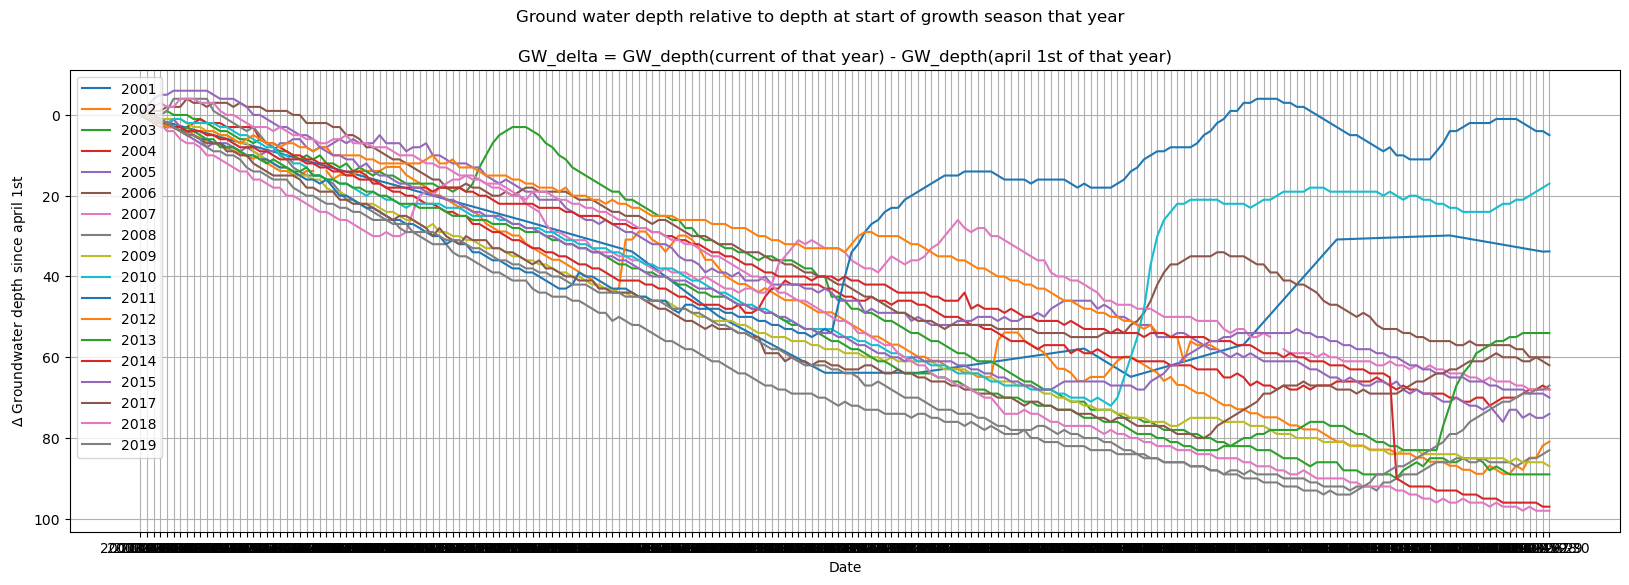

In [70]:
df_GWS_multi # all years

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20,6)

fig,ax = plt.subplots()
#ax.set_ylim(0,1.5)
ax.set_ylabel(r'$\Delta$ Groundwater depth since april 1st')
ax.set_xlabel('Date')

#plt.xticks([x for x in range(14,41)]) #this sets the xticks for the main x-axis with the weeknr
#locs, labels=plt.xticks() #this same function with no argument gets the position and labels and stores them for later

#fig.subplots_adjust(bottom=0.2)



colored_years={'2003':'green','2006':'orange','2011':'#b62020','2013':'purple','2018':'blue'}

for year in ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2017','2018','2019']:
    start=year+'-04-01'
    end=year+'-10-30'
    if year in colored_years.keys():
        color=colored_years[year]
        marker=''
    else:
        color='grey'
        marker=''
    ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker ,label=year) 
ax.legend(loc=("upper left"))
ax.invert_yaxis()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

fig.suptitle('Ground water depth relative to depth at start of growth season that year')
ax.set_title('GW_delta = GW_depth(current of that year) - GW_depth(april 1st of that year)')
ax.grid()

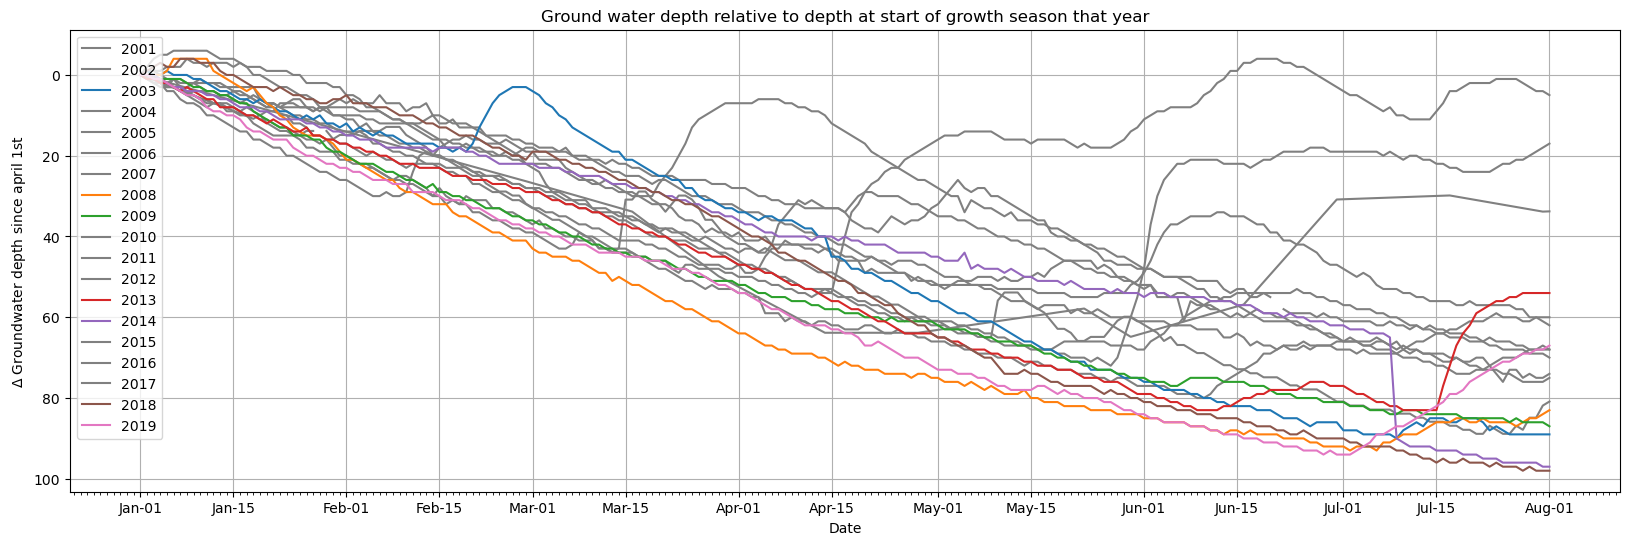

In [57]:
## df_GWS_multi #years that stay down

#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams["figure.figsize"] = (18,5)
plt.rcParams["figure.figsize"] = (20,6)

fig,ax = plt.subplots()
#ax.set_ylim(0,1.5)
ax.set_ylabel(r'$\Delta$ Groundwater depth since april 1st')
ax.set_xlabel('Date')

#plt.xticks([x for x in range(14,41)]) #this sets the xticks for the main x-axis with the weeknr
#locs, labels=plt.xticks() #this same function with no argument gets the position and labels and stores them for later

#fig.subplots_adjust(bottom=0.2)

#colored_years={'2003':'green','2008':'orange', 2009'2011':'#b62020','2013':'purple','2018':'blue'}
#2003 2008 2009 2010 (2011) 2013 2014  2018 2019

grey_years=['2001','2002','2004','2005','2006','2007','2010','2011','2012','2015','2016','2017']

#
for year in ['2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']:
    start=year+'-04-01'
    end=year+'-10-30'
    if year in grey_years:#colored_years.keys():
        marker=''
        ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker, color='grey' ,label=year)
    else:
        marker=''
        ax.plot(df_GWS_multi['yeardate'],df_GWS_multi['depth_'+year+'_diff'], marker=marker, zorder=3 ,label=year)
ax.legend(loc=("upper left"))
ax.invert_yaxis()
ax.xaxis.set_minor_locator(mdates.DayLocator())
ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=[1,15]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))

#fig.suptitle('Ground water depth relative to depth at start of growth season that year')
ax.set_title('Ground water depth relative to depth at start of growth season that year')
#ax.set_title('GW_delta = GW_depth(current of that year) - GW_depth(april 1st of that year)')
ax.grid()

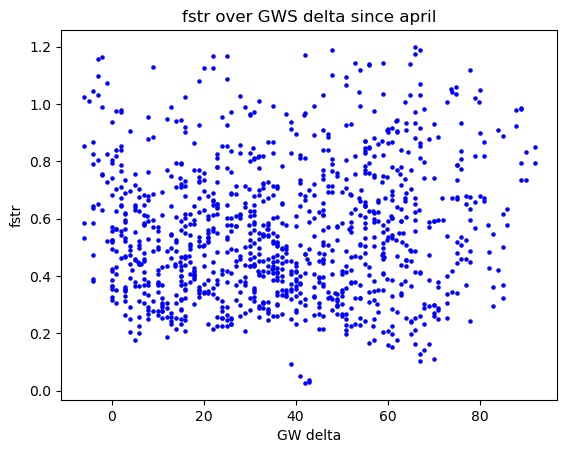

In [31]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)

#parallel processing

#df_GWS_multi7d=df_GWS_multi.iloc[:,2:].resample('7D').mean()

df_1d=pd.DataFrame()

df_1d=df_tmp3h.resample('1D').mean()

#df_1d=df_tmp30m.resample('1D').mean()
#df_1d['P(mast)']=df_tmp30m['P(mast)'].resample('1D').sum() #precip needs to be sum, not mean.

df_1d=df_1d.loc[df_1d['P(mast)']==0.0]
df_1d=df_1d.loc[df_1d['RD']==0.0] #knmi rain data

df_1d['LE/ET']=df_1d['LE']/df_1d['ET']
df_1d=df_1d.loc[df_1d['LE/ET']<1.2]

#df_1d=df_1d.merge(df_GWS_multi['GWS_2003_diff'], how='inner',left_index=True, right_index=True)
#df_1d=df_1d.merge(dfGWS['anom'], how='inner',left_index=True, right_index=True)

fig, ax = plt.subplots()

for year in range(2001,2020):
    
    st=str(year)+"-04-01"
    ed=str(year)+"-09-30"
    st2="2000-04-01" #due to df_GWS_multi being indexed to the year 2000, we need extra set of st and ed
    ed2="2000-09-30"
    GWS_key='GWS_'+str(year)+'_diff' #the column name to ask for
    df_tmp=pd.DataFrame()
    df_tmp[GWS_key]=df_GWS_multi.loc[st2:ed2,[GWS_key]]
    df_tmp['rel_date'] = df_tmp.index.strftime(date_format=str(year)+'-%m-%d')
    df_tmp['rel_date'] = pd.to_datetime(df_tmp['rel_date'],format='%Y-%m-%d')
    df_tmp.index=df_tmp['rel_date']
    #print(df_tmp.index)

    df_tmp=df_tmp.merge(df_1d.loc[st:ed,['LE/ET']], how='inner',left_index=True, right_index=True)
    ax.scatter(df_tmp[GWS_key],df_tmp['LE/ET'],color='b',s=5)
    ax.set_xlabel('GW delta')
    ax.set_ylabel('fstr')
    #ax.set_xlim(-5,90)
    #ax.set_ylim(0,1.2)
    ax.set_title('fstr over groundwater level change since april, \n ')

    #plt.show()

#df_GWS_multi7d

C:\Users\feder\AppData\Local\Temp\ipykernel_28500\2829906691.py:38: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_1d_seq = pd.concat([df_1d_seq,df_tmp],axis='index') #vertical join, along index


R2:  0.01271551088229896
slope, intercept: 0.0008523553350087357 0.5361329220274066


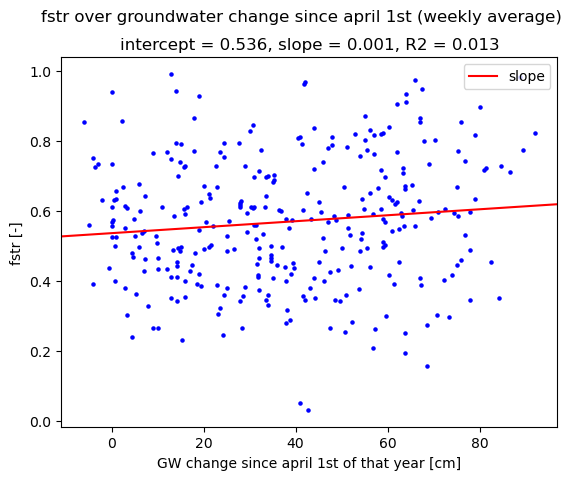

In [39]:
plt.rcParams["figure.figsize"] = (6.4, 4.8)

#sequential processing of GWS diff
#df_GWS_multi7d=df_GWS_multi.iloc[:,2:].resample('7D').mean()

df_1d=pd.DataFrame()

df_1d=df_tmp3h.resample('1D').mean()

#df_1d=df_tmp30m.resample('1D').mean()
#df_1d['P(mast)']=df_tmp30m['P(mast)'].resample('1D').sum() #precip needs to be sum, not mean.

df_1d=df_1d.loc[df_1d['P(mast)']==0.0]
df_1d=df_1d.loc[df_1d['RD']==0.0] #knmi rain data

df_1d['LE/ET']=df_1d['LE']/df_1d['ET']
df_1d=df_1d.loc[df_1d['LE/ET']<1.0]

df_1d_seq=pd.DataFrame() #sequential dataframe

for year in range(2001,2020):
    
    st=str(year)+"-04-01"
    ed=str(year)+"-09-30"
    st2="2000-04-01" #due to df_GWS_multi being indexed to the year 2000, we need extra set of st and ed
    ed2="2000-09-30"
    GWS_key='GWS_'+str(year)+'_diff' #the column name to ask for
    df_tmp=pd.DataFrame()
    df_tmp[GWS_key]=df_GWS_multi.loc[st2:ed2,[GWS_key]]
    df_tmp['rel_date'] = df_tmp.index.strftime(date_format=str(year)+'-%m-%d')
    df_tmp['rel_date'] = pd.to_datetime(df_tmp['rel_date'],format='%Y-%m-%d')
    df_tmp.index=df_tmp['rel_date']
    df_tmp=df_tmp.merge(df_1d.loc[st:ed,['LE/ET']], how='inner',left_index=True, right_index=True)
    #after this merge is done we can rename the GWS column
    df_tmp.rename(columns={GWS_key:'GWS_diff'},inplace=True)
    #print(df_tmp.columns)
    df_1d_seq = pd.concat([df_1d_seq,df_tmp],axis='index') #vertical join, along index
    df_1d_seq = df_1d_seq.dropna() #remove entries where there are at least one nan

df_1d_seq=df_1d_seq.resample('7D').mean()
df_1d_seq=df_1d_seq.dropna()

fig, ax = plt.subplots()
ax.scatter(df_1d_seq['GWS_diff'],df_1d_seq['LE/ET'],color='b',s=5)

slope, intercept, r_value, p_value, std_err = stats.linregress(df_1d_seq['GWS_diff'],df_1d_seq['LE/ET'])  #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
#ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')

ax.set_xlabel('GW change since april 1st of that year [cm]')
ax.set_ylabel('fstr [-]')
#ax.set_xlim(-5,90)
#ax.set_ylim(0,1.2)
fig.suptitle('fstr over groundwater change since april 1st (weekly average)')
ax.set_title('intercept = {:.3f}, slope = {:.3f}, R2 = {:.3f}'.format(intercept,slope,r_value**2))
ax.legend(loc='upper right')

plt.show()
#df_1d_seq.head(50)

#df_GWS_multi7d

In [297]:
#proof of concept snippet
e=df_tmp30m.loc['2003-01-01':'2003-01-15',['P(mast)']]
e=e.resample('3H').sum()
#e['event']=e.any(e['P(mast)']!=0.0)

e['time_since']=np.nan
counter=0

for index, row in e.iterrows():
    if row['P(mast)']==0.0:
        counter=counter+1
        e.loc[index,'time_since']=counter
    else:
        counter=0
        e.loc[index,'time_since']=counter

#e.head(40)

In [27]:
#old method
#new location put 88
dir = '../Dinoloket_2024-01-20/Grondwaterstanden_Put/B32F0088001_1_edit.csv'
df_GWS=pd.read_csv(dir,sep=",",index_col=False)
df_GWS=df_GWS.drop(['Locatie','Filternummer','Bijzonderheid','Opmerking'], axis=1)
#df_GWS['Peildatum']=df_GWS['Peildatum']+" 12:00"
df_GWS['datetime']=pd.to_datetime(df_GWS['Peildatum'], dayfirst=True, format='mixed')
df_GWS.index = df_GWS['datetime']
df_GWS=df_GWS.drop(['Peildatum','datetime'], axis=1)
st="2001-01-01"
ed="2019-12-30"
df_GWS=df_GWS.loc[st:ed]
avg_GWS = df_GWS['Stand (cm t.o.v. MV)'].mean()
df_GWS['anom'] = df_GWS.loc[st:ed,'Stand (cm t.o.v. MV)']-avg_GWS

df_GWS_7d=df_GWS.resample('7D').interpolate()
avg_GWS_7d = df_GWS_7d['Stand (cm t.o.v. MV)'].mean()
df_GWS_7d['anom']=df_GWS_7d.loc[st:ed,'Stand (cm t.o.v. MV)']-avg_GWS_7d
df_GWS_7d.index=df_GWS_7d.index.astype('datetime64[s]')

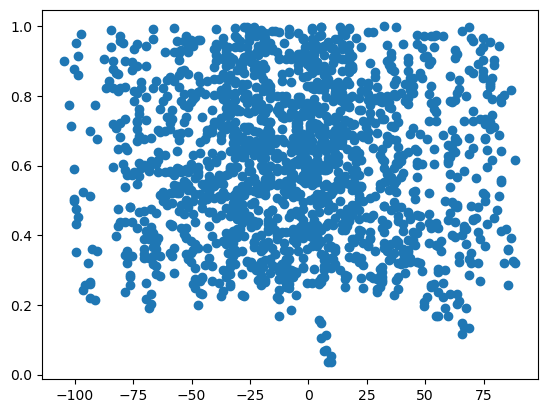

In [23]:
#old plot
df_tmp30m=pd.DataFrame()
df_tmp30m['ET']=df_ET['ET_VPD']
df_tmp30m=df_tmp30m.dropna()

df_LE=df_Comb['LE'].loc[df_Comb['LE']>=0]
df_tmp30m=df_tmp30m.merge(df_LE, how='inner',left_index=True, right_index=True)
df_1d=df_tmp30m.resample('1D').sum()

df_1d['LE/ET']=df_1d['LE']/df_1d['ET']
df_1d=df_1d.loc[df_1d['LE/ET']<1.0]

fig,ax = plt.subplots()

st="2011-04-01"
ed="2011-09-30"


df_1d=df_1d.merge(df_GWS['anom'], how='inner',left_index=True, right_index=True)
#df_1d=df_1d.merge(dfGWS['anom'], how='inner',left_index=True, right_index=True)

ax.scatter(df_1d['anom'],df_1d['LE/ET'])

R2:  0.0005815820158081806
slope, intercept: 0.0003359813070294066 0.6533469376342603


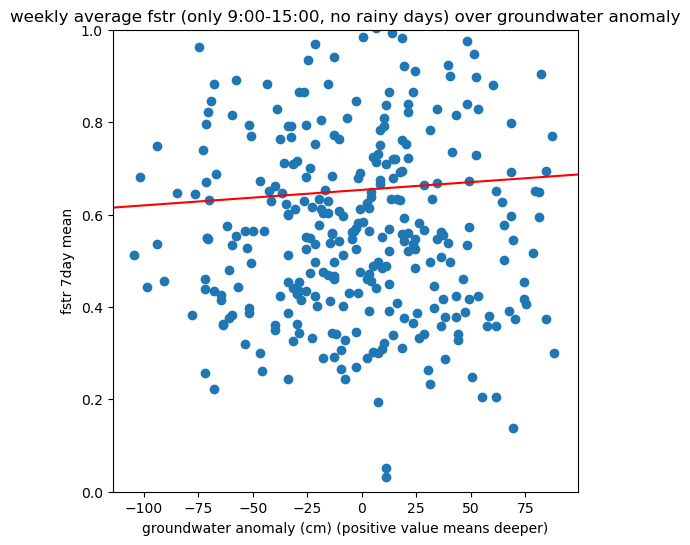

In [46]:
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (6,6)

#df_tmp7d_1=df_tmp7d.copy()
#df_tmp1d_1=df_tmp1d_1.loc[df_tmp1d_1['LE/ET']<1.0]

fig,ax = plt.subplots()

#st="2011-04-01"
#ed="2011-09-30"

#df_GWS_7d['Stand (cm t.o.v. MV)']
df_tmp7d_1=pd.merge_asof(df_tmp7d,df_GWS_7d['anom'],left_index=True, right_index=True,direction='backward')
#df_1d=df_1d.merge(dfGWS['anom'], how='inner',left_index=True, right_index=True)

ax.scatter(df_tmp7d_1['anom'],df_tmp7d_1['LE/ET'])

ax.set_ylim(0,1)
ax.set_title('weekly average fstr (only 9:00-15:00, no rainy days) over groundwater anomaly')
#fstr over groundwater change since april 1st (weekly average)'
ax.set_ylabel('fstr 7day mean')
ax.set_xlabel('groundwater anomaly (cm) (positive value means deeper)')

import scipy.stats as stats

df_tmp7d_1=df_tmp7d_1.dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp7d_1['anom'], df_tmp7d_1['LE/ET']) #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
#ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')

R2:  nan
slope, intercept: nan nan


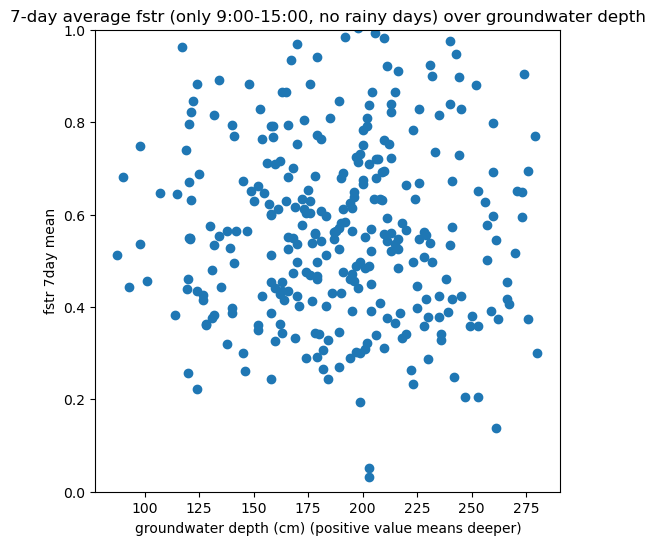

In [86]:
#plt.rcParams["figure.figsize"] = plt.rcParamsDefault
#plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (6,6)

#df_tmp7d_1=df_tmp7d.copy()
#df_tmp1d_1=df_tmp1d_1.loc[df_tmp1d_1['LE/ET']<1.0]

fig,ax = plt.subplots()

#st="2011-04-01"
#ed="2011-09-30"

#df_GWS_7d['Stand (cm t.o.v. MV)']
df_tmp7d_1=pd.merge_asof(df_tmp7d,df_GWS_7d['Stand (cm t.o.v. MV)'],left_index=True, right_index=True,direction='backward')
#df_1d=df_1d.merge(dfGWS['anom'], how='inner',left_index=True, right_index=True)

ax.scatter(df_tmp7d_1['Stand (cm t.o.v. MV)'],df_tmp7d_1['LE/ET'])

ax.set_ylim(0,1)
ax.set_title('7-day average fstr (only 9:00-15:00, no rainy days) over groundwater depth')
ax.set_ylabel('fstr 7day mean')
ax.set_xlabel('groundwater depth (cm) (positive value means deeper)')

import scipy.stats as stats

slope, intercept, r_value, p_value, std_err = stats.linregress(df_tmp7d_1['Stand (cm t.o.v. MV)'], df_tmp7d_1['LE/ET']) #linregres x, y . note r_value is Pearson's coefficient. R^2 is r_value**2
print('R2: ',r_value**2)
print('slope, intercept:', slope, intercept)
ax.axline((0.0,intercept),slope=slope,c='r',label='slope')
#ax.axline ((0.0,0.0), slope=1, c='r',linestyle='dashed',label='1:1')

In [52]:
df_soil_7d_sm3_mean=df_soil_7d['SM-003'].mean()
df_soil_7d_lit_mean=df_soil_7d['SM-Lit'].mean()
df_soil_7d['SM-003_anom']=df_soil_7d['SM-003']-df_soil_7d_sm3_mean
df_soil_7d['SM-Lit_anom']=df_soil_7d['SM-Lit']-df_soil_7d_lit_mean